In [1]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import sys
sys.path = ['..', '../../../rllab'] + sys.path
from baselines.pois.testing import evaluate
from baselines import logger

/Users/nicom/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
logs_names = glob('../tmp_logs/*.txt')

def parse_params(lines):
    points = []
    for i, line in enumerate(lines):
        if '| Bound' in line:
            param_line = lines[i-4]
            reward_line = lines[i+6]
            params = list(map(float, param_line[1:-2].split()))
            reward = float(reward_line.split('|')[2])
            points.append(params + [reward])
    return points
  
logs, logs_length = [], []
for i, file in enumerate(logs_names):
    with open(file) as f:
        lines = f.readlines()
        p = parse_params(lines)
        logs.extend(p)
        logs_length.append(len(p))
logs = np.array(logs)

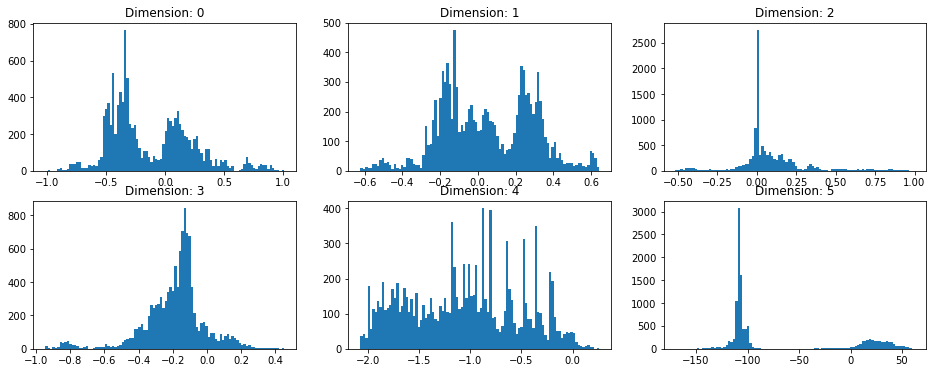

In [3]:
fig, ax = plt.subplots(2, 3, figsize=(16, 6))
for i in range(6):
    ax[i//3, i%3].hist(logs[:, i], bins=100)
    ax[i//3, i%3].set_title('Dimension: %s'%(i,))
plt.show();

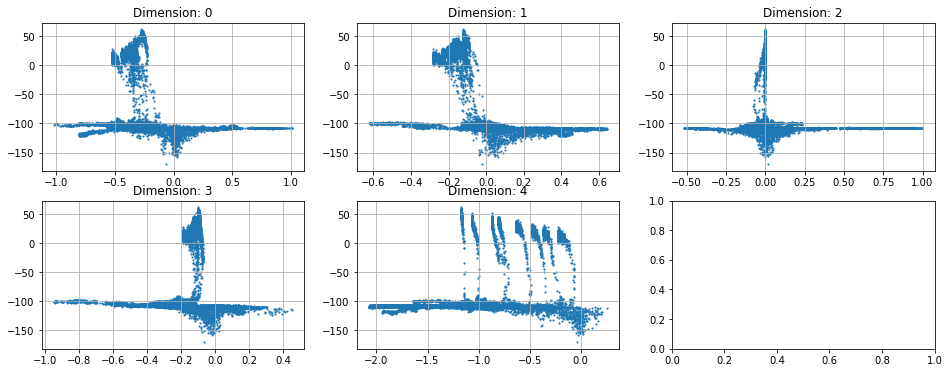

In [4]:
fig, ax = plt.subplots(2, 3, figsize=(16, 6))
for i in range(5):
    ax[i//3, i%3].scatter(logs[:,i], logs[:,5], s=1.2)
    ax[i//3, i%3].set_title('Dimension: %s'%(i,))
    ax[i//3, i%3].grid()
plt.show();

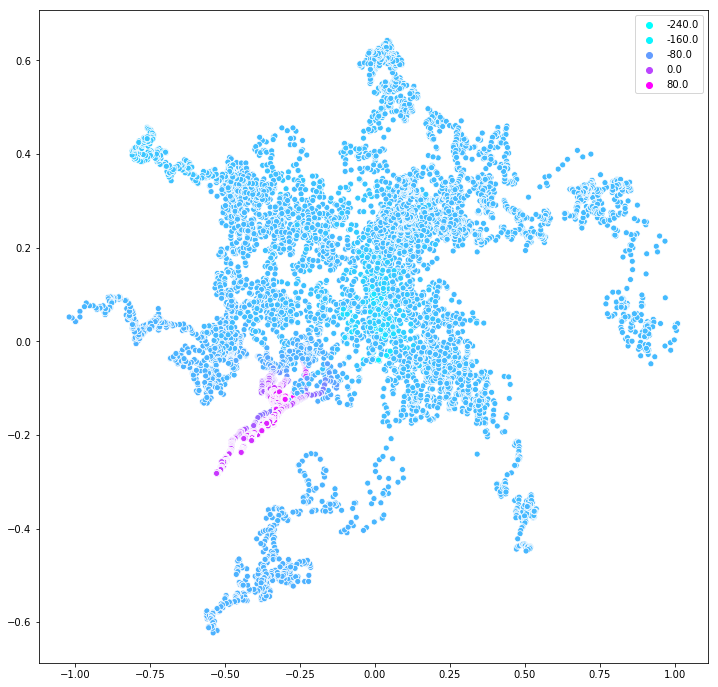

In [5]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x=logs[:,0], y=logs[:,1], hue=logs[:,5], palette='cool')
plt.show();

HIGHLIGHTED RUN FINAL REWARD: 34.3


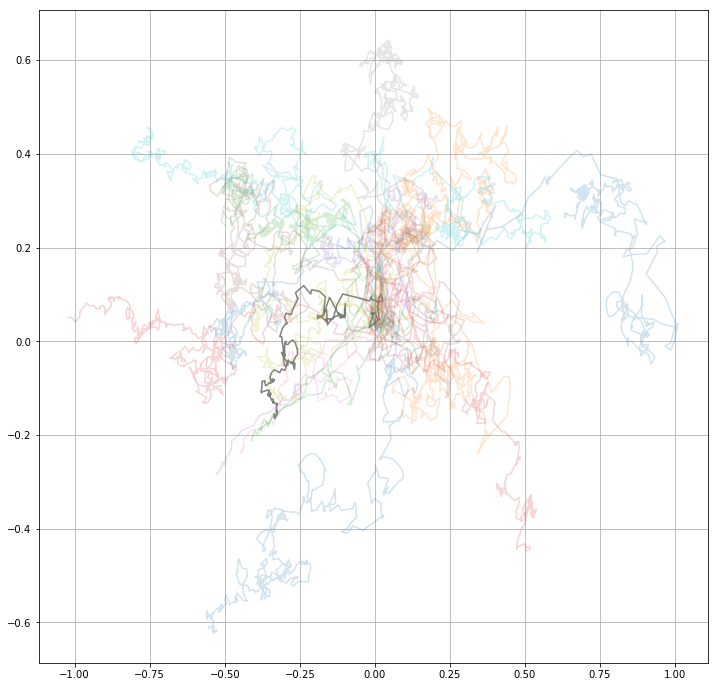

In [6]:
fig, ax = plt.subplots(figsize=(12, 12))
ci = 0
# GOOD RUNS:  6, 7, 8, 12, 14, 16, 18, 22
HIGHLIGHT = 7
print('HIGHLIGHTED RUN FINAL REWARD:', logs[sum(logs_length[:HIGHLIGHT+1])-1,5])
for i, log_len in enumerate(logs_length):
    ax.plot(logs[ci:ci+log_len,0], logs[ci:ci+log_len,1], alpha=1.0 if HIGHLIGHT == i else 0.2)
    ci += log_len
    ax.grid()
plt.show();

## Grid-search of parameters

In [11]:
base_args = {'n_episodes': 10, 'horizon': 500, 'njobs': 4, 'env': 'rllab.inverted-pendulum', 'policy': 'linear'}
logger.configure(dir='.', format_strs=[], file_name='x')

def evaluate_theta(theta):
    s = evaluate(theta, seed=42, **base_args)
    return np.sum(s['rew']) / base_args['n_episodes']

In [12]:
for p0 in np.arange(-1.0, 0.5, 0.1):
    for p1 in np.arange(-0.4, 0.4, 0.1):
        theta = np.array([p0, p1] + [0.1, -0.18, -1.0])
        print(evaluate_theta(theta))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


KeyboardInterrupt: 